# Residual Networks

- 앞선 네트워크에서 설명한 부분은 생략했습니다.
- 2015 ILSVRC 1st place
- ResNet-50

![alt text](https://www.codeproject.com/KB/AI/1248963/resnet.png)


In [1]:
# 런타임 유형 GPU 모드로 변경
!pip install torch torchvision

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

  Using cached Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl (5.7 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1 requires pillow!=8.3.0,>=5.3.0, but you have pillow 4.1.1 which is incompatible.
matplotlib 3.3.4 requires pillow>=6.2.0, but you have pillow 4.1.1 which is incompatible.


In [2]:
# !rm -r images

# import os 

# # 이미지 파일을 저장할 폴더를 생성합니다.
# try:
#   os.mkdir("../Data/images")
#   os.mkdir("../Data/images/dogs")
#   os.mkdir("../Data/images/cats")
# except:
#   pass

# # 이미지들을 지정한 위치에 다운로드합니다.
# # images/dogs 밑에 2개
# !wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P ../Data/images/dogs
# !wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P ../Data/images/dogs

# # images/cats 밑에 2개
# !wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P ../Data/images/cats
# !wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P ../Data/images/cats

## 1. Settings
### 1) Import required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.auto import trange

### 2) Hyperparameter

In [4]:
batch_size= 50
learning_rate = 0.0001
num_epoch = 100

## 2. Data Loader

In [5]:
img_dir = "../Data/images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, drop_last=True, num_workers=2)

## 3. Model 
### 1) Basic Block

- 컨볼루션 연산과 활성화함수는 항상 붙어 있기 때문에 이를 함수로 만들었습니다.

In [6]:
def conv_block_1(in_dim,out_dim,act_fn,stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=1, stride=stride),
        act_fn,
    )
    return model


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        act_fn,
    )
    return model

### 2) Bottle Neck Module
- Bottle Neck 모듈은 [1x1 컨볼루션 -> 3x3 컨볼루션 -> 1x1 컨볼루션]으로 이루어집니다.
- 맨 위에 네트워크 구조에서도 볼 수 있듯이 실선은 크기가 변하지 않는 경우, 점선은 크기가 줄어드는 경우입니다. 
- 이를 한번에 구현하기 위해 down이라는 변수로 크기 감소 여부를 표시하고 조건문으로 경우의 수를 나눠 구현했습니다.
- 또한 ResNet의 Skip-connection은 단순 더하기로 정의되어 있기 때문에 특성지도의 크기를 일치시켜야 합니다. 
- 이를 위해 차원을 맞춰주는 역할로 dim_equalizer라는 것을 정의했습니다.

In [7]:
class BottleNeck(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn,down=False):
        super(BottleNeck,self).__init__()
        self.down=down
        
        # 특성지도의 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_dim,mid_dim,act_fn,2),
              conv_block_3(mid_dim,mid_dim,act_fn),
              conv_block_1(mid_dim,out_dim,act_fn),
            )
            self.downsample = nn.Conv2d(in_dim,out_dim,1,2)
            
        # 특성지도의 크기가 그대로인 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_dim,mid_dim,act_fn),
                conv_block_3(mid_dim,mid_dim,act_fn),
                conv_block_1(mid_dim,out_dim,act_fn),
            )
            
        # 더하기를 위해 차원을 맞춰주는 부분
        self.dim_equalizer = nn.Conv2d(in_dim,out_dim,kernel_size=1)
                  
    def forward(self,x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out


### 2) ResNet Model

In [8]:
class ResNet(nn.Module):

    def __init__(self, base_dim, num_classes=2):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),            
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim*16,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
        )
        self.avgpool = nn.AvgPool2d(7,1) 
        self.fc_layer = nn.Linear(base_dim*32,num_classes)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out


## 4. Optimizer & Loss

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
model = ResNet(base_dim=64).to(device)

'''
for i in model.children():
    print(i)
'''

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

cuda:0


## 5. Train

In [10]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7000, device='cuda:0', grad_fn=<NllLossBackward0>)



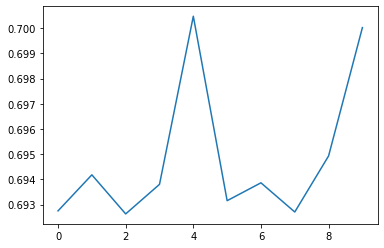

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()